In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

2025-10-01 15:10:55.299865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759331455.672157      70 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759331455.775081      70 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Training samples: {len(x_train)}, Test samples: {len(x_test)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training samples: 50000, Test samples: 10000


In [4]:
# ==================== 2. PREPROCESSING ====================
# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [5]:
# ==================== 3. DATASET PIPELINE ====================
def create_dataset_pipeline(x, y, batch_size=32, training=True):
    """Memory-efficient dataset pipeline with resizing"""
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    
    if training:
        dataset = dataset.shuffle(1000)
    
    def resize(image, label):
        image = tf.image.resize(image, [224, 224])
        return image, label
    
    dataset = dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

batch_size = 16
train_ds = create_dataset_pipeline(x_train, y_train, batch_size, training=True)
test_ds = create_dataset_pipeline(x_test, y_test, batch_size, training=False)

I0000 00:00:1759331478.839971      70 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759331478.840644      70 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
def visualize_batch(images_batch, labels_batch, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images_batch))):
        # Get the label index and corresponding class name
        label_idx = int(labels_batch[i][0])
        class_name = class_names[label_idx]
        
        # Display image
        axes[i].imshow(images_batch[i])
        axes[i].set_title(f'{class_name}', fontsize=12)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

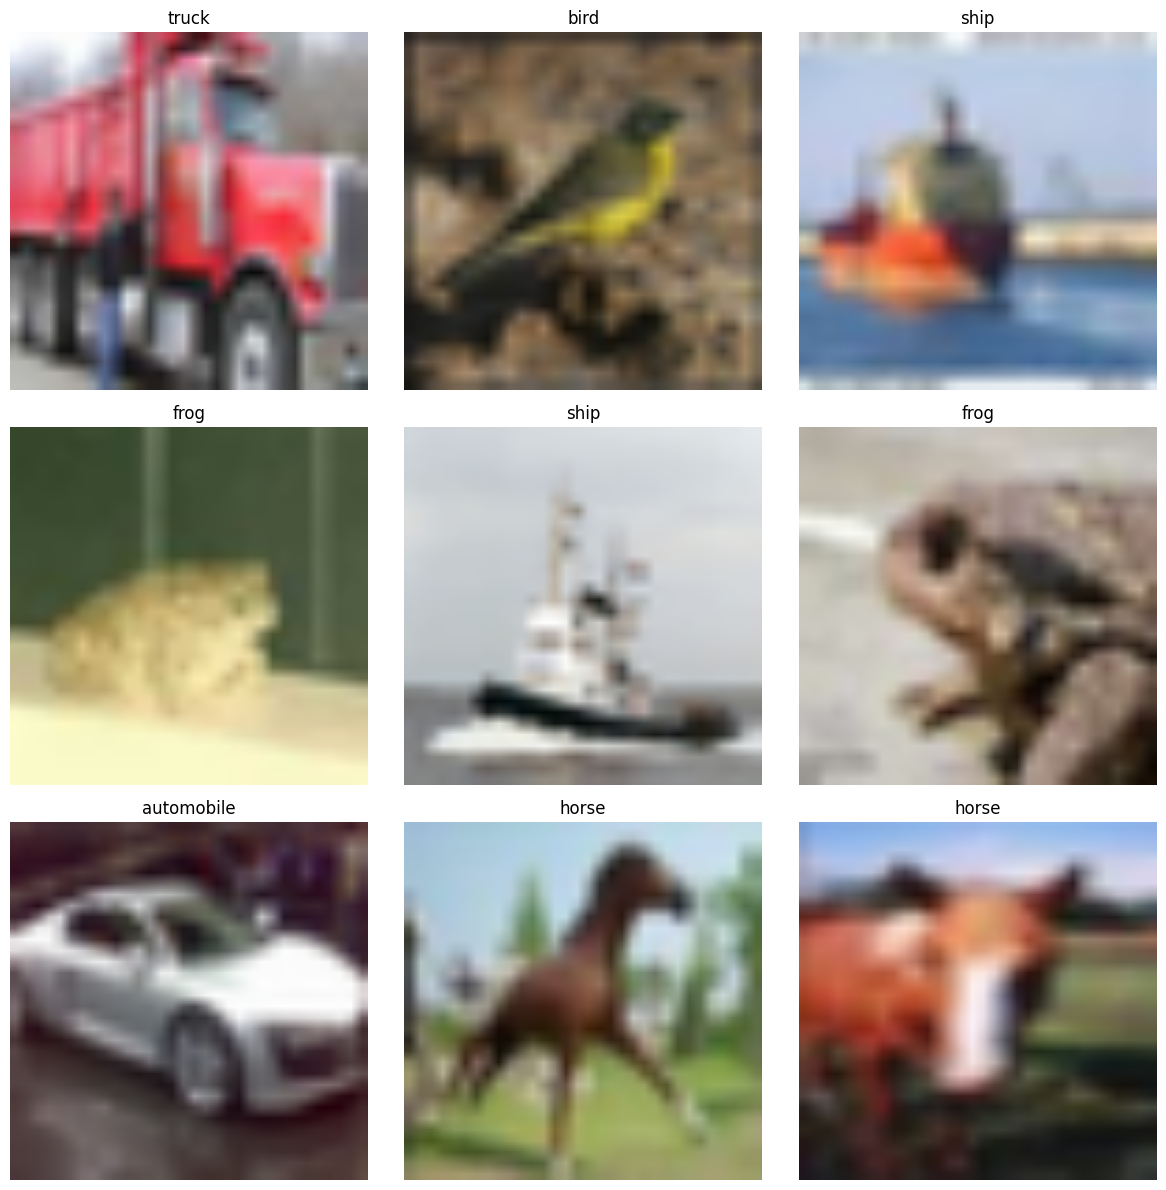

In [8]:
for images, labels in train_ds.take(1):
    visualize_batch(images, labels)

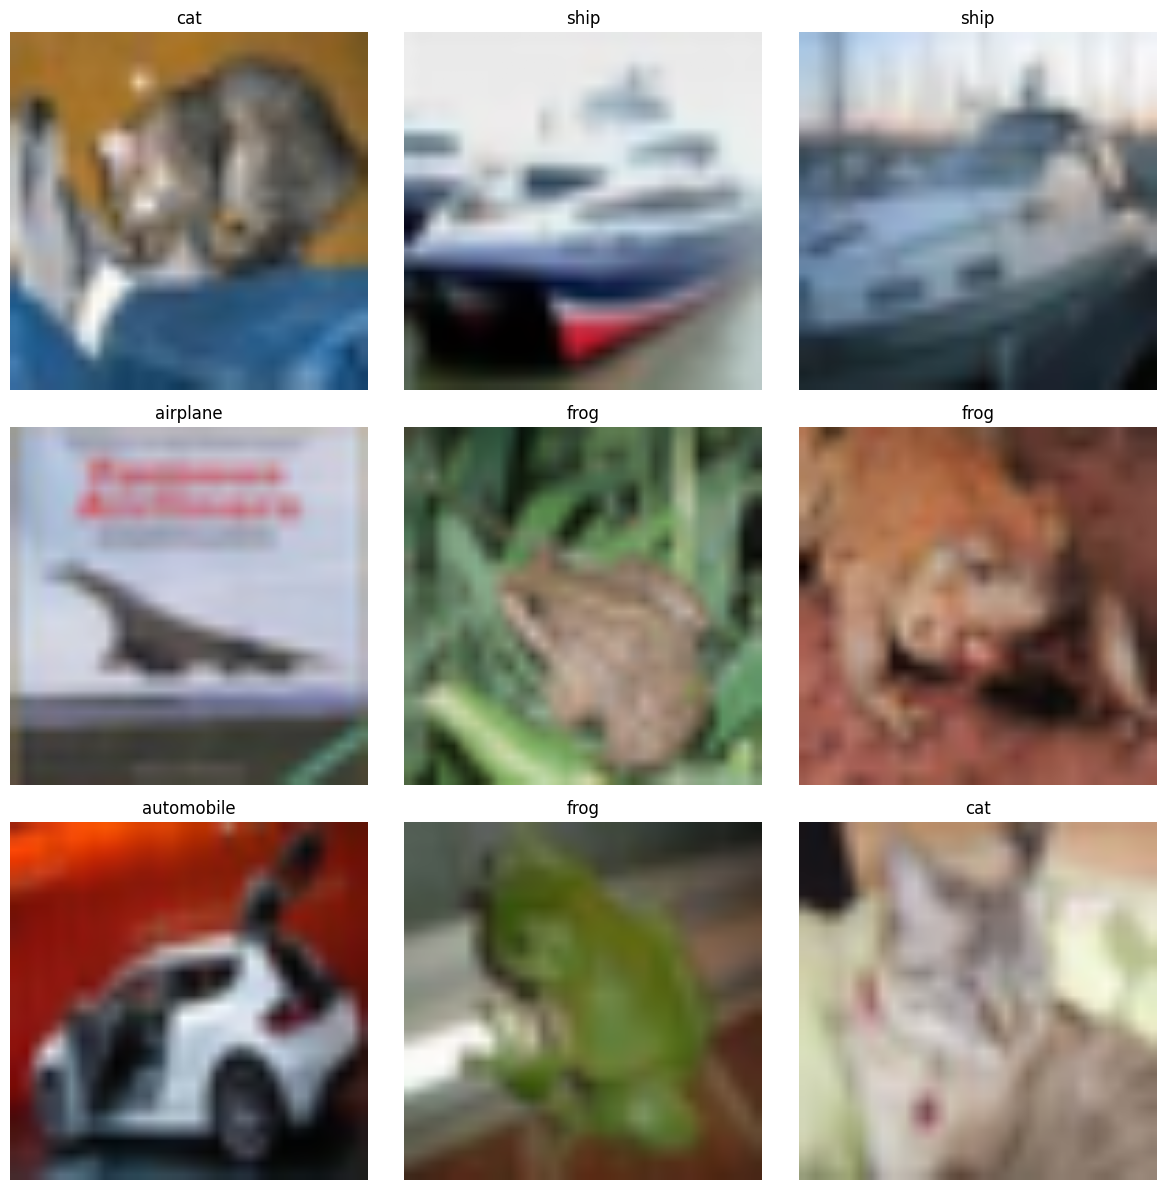

In [9]:
for images, labels in test_ds.take(1):
    visualize_batch(images, labels)

In [10]:
# ==================== 4. BUILD MODEL ====================
print("\nBuilding MobileNetV2 transfer learning model...")

# Load pretrained MobileNetV2
pretrained_base = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)


Building MobileNetV2 transfer learning model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
pretrained_base.trainable = False  # Freeze base model

In [12]:
# Build transfer learning model
transfer_model = models.Sequential([
    pretrained_base,
    layers.GlobalAveragePooling2D(name='gap_tl'),
    layers.Dense(128, activation='relu', name='fc_tl'),
    layers.Dropout(0.5, name='dropout_tl'),
    layers.Dense(10, activation='softmax', name='output_tl')
])

In [13]:
# Compile model
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
transfer_model.summary()


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap_tl (GlobalAveragePooling2D) │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_tl (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_tl (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_tl (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# ==================== 5. TRAIN MODEL ====================
print("\nTraining model...")
history = transfer_model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    verbose=1
)


Training model...
Epoch 1/10


I0000 00:00:1759331494.017130     102 service.cc:148] XLA service 0x7b80b4005260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759331494.019149     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759331494.019169     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759331494.954779     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/3125 ━━━━━━━━━━━━━━━━━━━━ 1:20 26ms/step - accuracy: 0.0872 - loss: 2.8184      

I0000 00:00:1759331499.882635     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.6258 - loss: 1.0827 - val_accuracy: 0.7743 - val_loss: 0.6416
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.7386 - loss: 0.7647 - val_accuracy: 0.7915 - val_loss: 0.6002
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.7553 - loss: 0.7188 - val_accuracy: 0.7988 - val_loss: 0.5830
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.7638 - loss: 0.6831 - val_accuracy: 0.8067 - val_loss: 0.5600
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.7763 - loss: 0.6556 - val_accuracy: 0.8066 - val_loss: 0.5604
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.7801 - loss: 0.6360 - val_accuracy: 0.8047 - val_loss: 0.5713
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.7869 - loss: 0.6192 - val_accuracy: 0.8088 - val_loss: 0.5601
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.7856 - loss: 0.61

In [15]:
# ==================== 6. EVALUATE MODEL ====================
print("\nEvaluating model on test set...")
test_loss, test_acc = transfer_model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Evaluating model on test set...
Test Accuracy: 81.04%
Test Loss: 0.5705


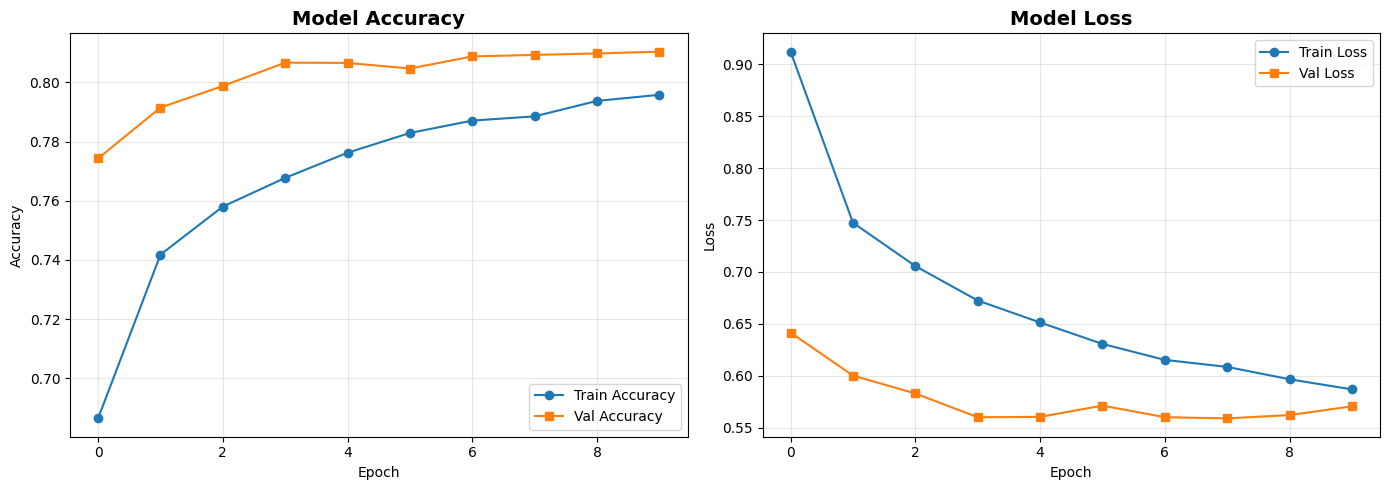

In [16]:
# ==================== 7. PLOT TRAINING HISTORY ====================
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    ax1.set_title('Model Accuracy', fontsize=14, weight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Val Loss', marker='s')
    ax2.set_title('Model Loss', fontsize=14, weight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

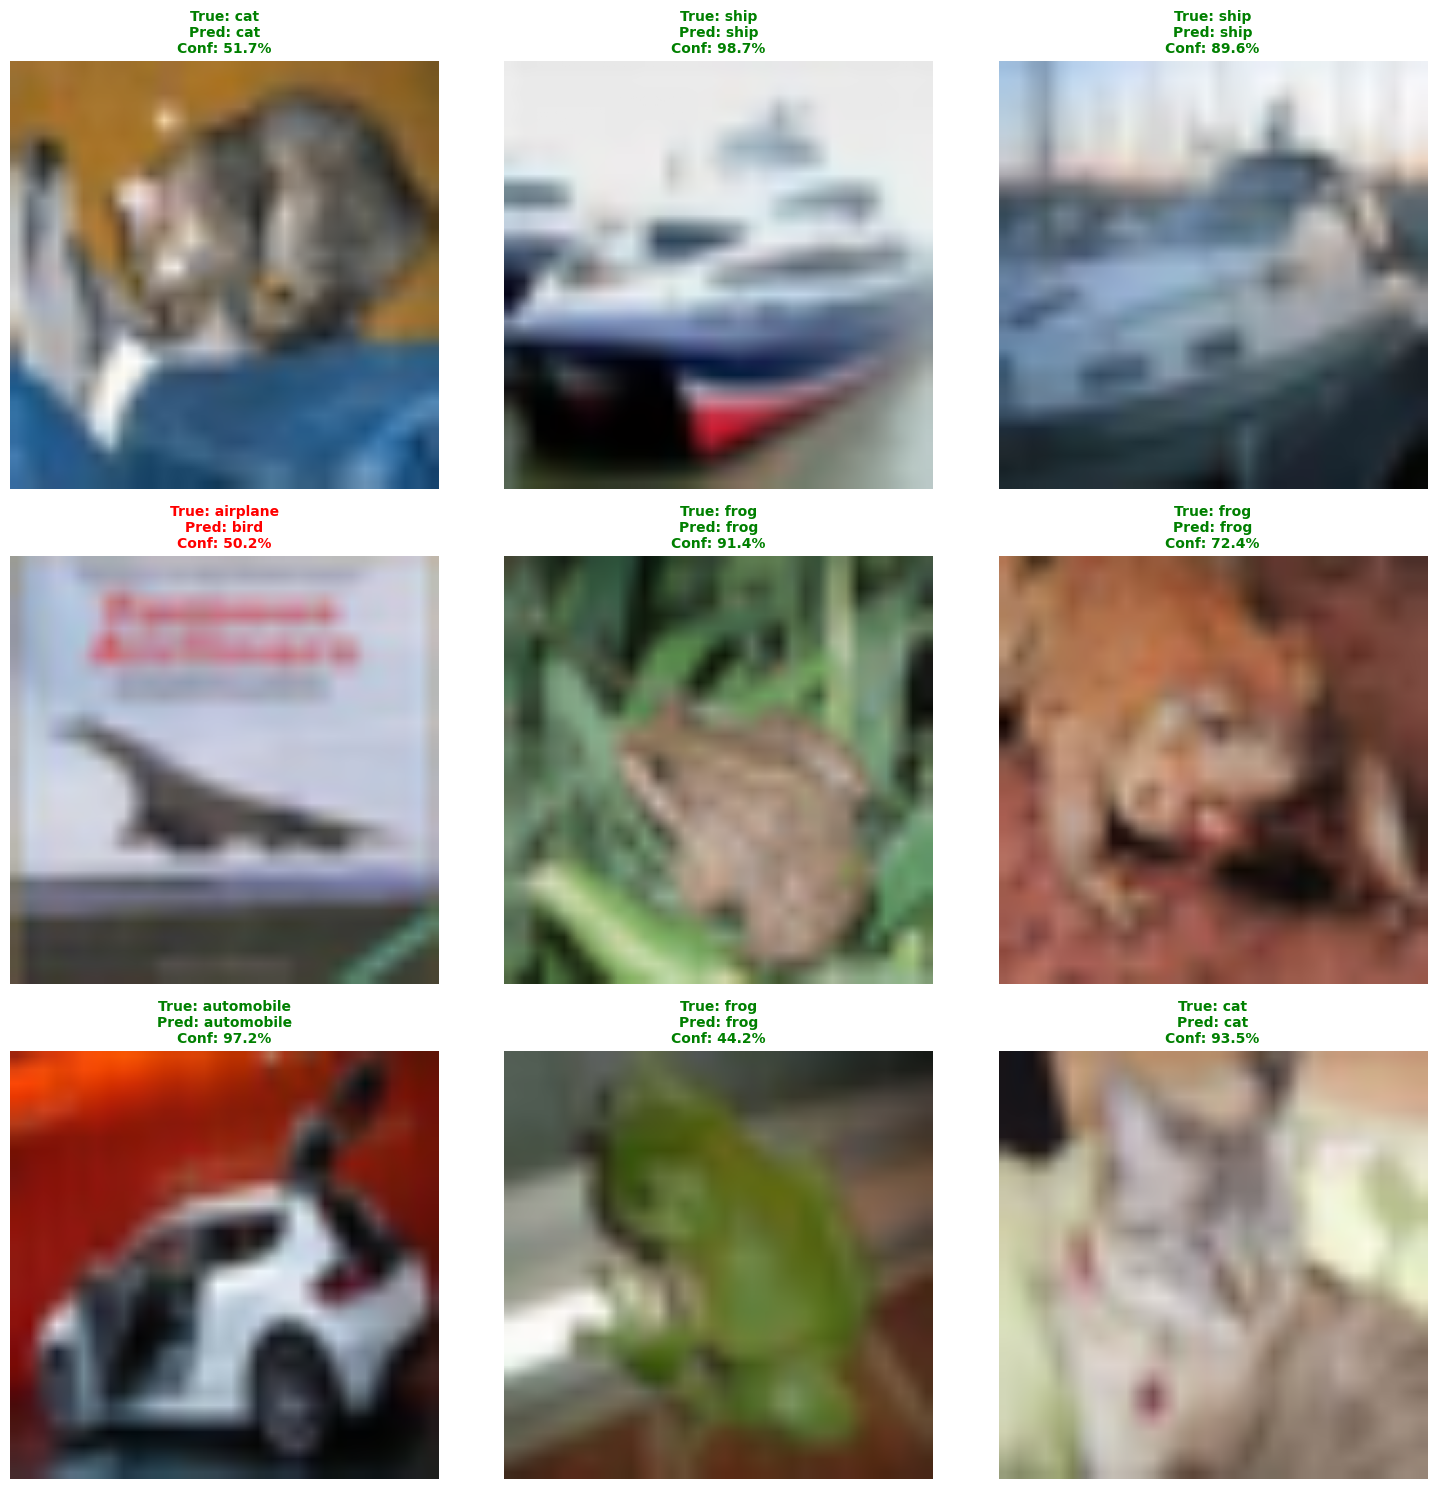

In [17]:
# ==================== 8. VISUALIZE PREDICTIONS ====================
def visualize_predictions(model, dataset, num_samples=9):
    for images_batch, labels_batch in dataset.take(1):
        predictions = model.predict(images_batch[:num_samples], verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.ravel()
        
        for i in range(min(num_samples, len(images_batch))):
            true_label = int(labels_batch[i])
            pred_label = predicted_classes[i]
            confidence = predictions[i][pred_label] * 100
            
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            
            # Normalize image for display
            img = images_batch[i].numpy()
            img = np.clip(img, 0, 1)
            
            axes[i].imshow(img)
            
            # Green for correct, red for incorrect
            color = 'green' if true_label == pred_label else 'red'
            title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%'
            axes[i].set_title(title, fontsize=10, color=color, weight='bold')
            axes[i].axis('off')
        
        for i in range(num_samples, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        break

visualize_predictions(transfer_model, test_ds, num_samples=9)

In [18]:
# ==================== 9. SAVE MODEL =====================
# transfer_model.save('cifar10_mobilenetv2.keras')
# print("\nModel saved as 'cifar10_mobilenetv2.keras'")